In [1]:
!pip install seaborn
!pip install nltk
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
import os.path as path
from pyspark.sql import SparkSession
from pyspark.sql import column
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer, VectorAssembler,OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [4]:
def init_spark():
  return SparkSession \
        .builder \
        .appName("Big data project") \
        .config("spark.executor.memory", "16g") \
        .config("spark.driver.memory", "16g") \
        .getOrCreate()

spark = init_spark()

24/04/03 18:19:37 WARN Utils: Your hostname, DESKTOP-968IKC4 resolves to a loopback address: 127.0.1.1; using 172.31.102.226 instead (on interface eth0)
24/04/03 18:19:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/03 18:19:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/03 18:19:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [5]:
def get_data_dataframe(dir="final_dataset.csv"):
    # Specify the directory where the CSV files are saved
    csv_directory = dir
    
    # Read the CSV files back into a DataFrame
    final_df_read = spark.read.option("header", "true").option("multiline", "true").csv(csv_directory)
    
    # Add a random column to shuffle data randomly
    shuffled_df = final_df_read.withColumn("rand", rand())
    shuffled_df = shuffled_df.orderBy("rand")
    final_df_read = shuffled_df.drop("rand")
    return final_df_read



In [6]:
df=get_data_dataframe("final_dataset_all_imdb.csv").limit(20000)


In [7]:
df.columns

['movie_id',
 'movie_name',
 'genre',
 'description',
 'director',
 'actor1',
 'actor2',
 'actor3']

In [8]:
df.take(2)

[Row(movie_id='tt11010888', movie_name='Student Body', genre='horror', description="High-school student Jane Shipley seeks to mend her splintering relationship with childhood best friend Merritt and fit in with her rebellious peers. When Jane's math teacher oversteps his ...                See full summary\xa0»", director='Lee Ann Kurr', actor1='Christian Camargo', actor2='Montse Hernandez', actor3='Cheyenne Haynes'),
 Row(movie_id='tt0097626', movie_name='Johnny Handsome', genre='crime', description='After being double crossed and thrown in jail, a deformed gangster gets a new face and rehabilitation, but his desire for revenge looms.', director='Walter Hill', actor1='Mickey Rourke', actor2='Ellen Barkin', actor3='Elizabeth McGovern')]

In [9]:
# df.drop("director","actor2","actor3")

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stopword = set(stopwords.words('english'))

def preprocessing(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove specific characters #, @, and $
    text = re.sub(r'[#@\$]', '', text)
    
    # tokenize and convert to list
    tokens = word_tokenize(text)
    
    ## Lemmatize it 
    lemmatizer  = WordNetLemmatizer()
    
    ## lemmatize each token
   # text = [lemmatizer.lemmatize(token) for token in tokens]
    text = text.split()
    
    text = [word for word in text if word not in stopword]
    
    
    return " ".join(text) 

[nltk_data] Downloading package punkt to /home/umang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/umang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/umang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# pdd=df.toPandas()
# # pdd.drop_duplicates(inplace = True)
# # pdd.dropna( inplace = True )
# pdd.size

In [12]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier,RandomForestClassificationModel

In [13]:
# df=combined_train_df

In [14]:
# df
# 

In [15]:
# Remove duplicate rows
df = df.dropDuplicates()

# Remove rows with null values
# df_no_null = df_no_duplicates.dropna()


In [16]:
df.count()

20000

In [17]:
# df=df_no_duplicates

In [18]:
# df = df.select([sum (col(c).isNull().cast("int")).alias(c) for c in df.columns])

# # Show the count of null values for each column
# df.show()


In [19]:
df = df.dropna()

In [20]:
# df = df.select([sum (col(c).isNull().cast("int")).alias(c) for c in df.columns])

# # Show the count of null values for each column
# df.show()
# Tokenization, stop word removal, and TF-IDF transformation for text data
director_indexer = StringIndexer(inputCol="director", outputCol="director_indexed")
actor1_indexer = StringIndexer(inputCol="actor1", outputCol="actor1_indexed")
actor2_indexer = StringIndexer(inputCol="actor2", outputCol="actor2_indexed")
actor3_indexer = StringIndexer(inputCol="actor3", outputCol="actor3_indexed")

tokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\\W")
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="description_clean")

# Encoding genre labels
genre_indexer = StringIndexer(inputCol="genre", outputCol="label")

assembler = VectorAssembler(inputCols=["description_clean"], outputCol="features")


pipeline = Pipeline(stages=[director_indexer,actor1_indexer,actor2_indexer,actor3_indexer,tokenizer,remover,vectorizer, idf,genre_indexer,assembler])
transformed_df = pipeline.fit(df).transform(df)
# Combine the preprocessed text features with the genre labels
# combined_train_df = genre_indexer.fit(transformed_train_df).transform(transformed_train_df)


In [21]:
df=transformed_df

In [22]:
# Split the data into training and testing sets
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Show the number of rows in each set
print("Training set count:", train_df.count())
print("Testing set count:", test_df.count())

24/04/03 18:20:33 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Training set count: 15330


24/04/03 18:20:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Testing set count: 3761


24/04/03 18:20:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


+---------+-----+
|    genre|count|
+---------+-----+
|adventure| 2994|
|  romance| 3078|
|   horror| 3108|
|    crime| 3135|
|   action| 3015|
+---------+-----+



24/04/03 18:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


       genre  count
0  adventure   2994
1    romance   3078
2     horror   3108
3      crime   3135
4     action   3015


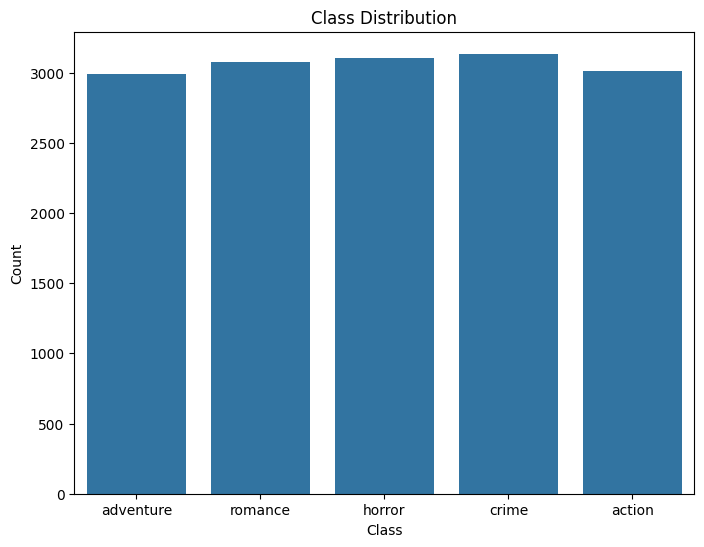

24/04/03 18:20:37 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


+---------+-----+
|    genre|count|
+---------+-----+
|adventure|  731|
|   horror|  810|
|   action|  751|
|  romance|  743|
|    crime|  726|
+---------+-----+



24/04/03 18:20:37 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


       genre  count
0  adventure    731
1     horror    810
2     action    751
3    romance    743
4      crime    726


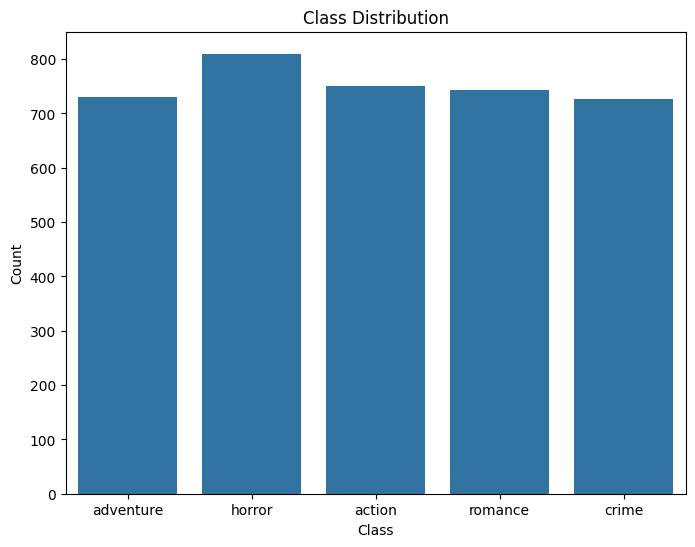

In [23]:
def print_class_distribution(df):
    # Group the DataFrame by the "genre" column and count the occurrences of each genre
    genre_counts = df.groupBy("genre").count()
    # Show the genre counts
    genre_counts.show()
    class_counts = genre_counts.toPandas()
    print(class_counts)
    plt.figure(figsize=(8, 6))
    sns.barplot(x="genre", y="count", data=class_counts)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()
    

# def show_class_frequency_distribution(df):
#        # Plot class distribution
#     plt.figure(figsize=(8, 6))
#     sns.barplot(x="class", y="count", data=class_counts)
#     plt.title("Class Distribution")
#     plt.xlabel("Class")
#     plt.ylabel("Count")
#     plt.show()
#     plt.savefig(plots_dir + '/class_distribution.jpeg', dpi=300, bbox_inches='tight')
    #plt.show()
print_class_distribution(train_df)
print_class_distribution(test_df)

In [24]:
df

DataFrame[movie_id: string, movie_name: string, genre: string, description: string, director: string, actor1: string, actor2: string, actor3: string, director_indexed: double, actor1_indexed: double, actor2_indexed: double, actor3_indexed: double, words: array<string>, filtered_words: array<string>, raw_features: vector, description_clean: vector, label: double, features: vector]

In [25]:
# show_class_frequency_distribution("./

In [26]:
def print_and_return_mapping_of_index_to_label(df,predicting='genre'):
    # Collect distinct pairs of (label, genre)
    label_genre_mapping = df.select("label", predicting).distinct().collect()
    map={}
    # Print the mapping
    for mapping in label_genre_mapping:
        print("Label %s is mapped to genre '%s'" % (mapping.label, mapping.genre))
        map[mapping.label]= mapping.genre
    return map

In [27]:
mapping=print_and_return_mapping_of_index_to_label(df)

Label 0.0 is mapped to genre 'horror'
Label 1.0 is mapped to genre 'crime'
Label 3.0 is mapped to genre 'action'
Label 4.0 is mapped to genre 'adventure'
Label 2.0 is mapped to genre 'romance'


In [28]:
mapping

{0.0: 'horror', 1.0: 'crime', 3.0: 'action', 4.0: 'adventure', 2.0: 'romance'}

In [29]:
# Train the model
# model = pipeline.fit(train_df)
# Define the Random Forest classifier
dt_classifier = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxBins=60000)



# Make predictions
# predictions = model.transform(test_df)

In [30]:
# Train the Random Forest classifier
model = dt_classifier.fit(df)

24/04/03 18:20:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/04/03 18:20:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
24/04/03 18:20:48 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 60000 to 19091 (= number of training instances)
24/04/03 18:20:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/04/03 18:21:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/03 18:21:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/03 18:21:10 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/03 18:21:13 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
24/04/03 18:21:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


In [31]:
# rfc_path = "models/rfc"

# rfc_model_path = "models/rfc_model"


In [32]:
# rf_classifier.save(rfc_path)
# model.save(rfc_model_path)

In [33]:
# model = RandomForestClassificationModel.load(rfc_model_path)

In [34]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

In [35]:
predictions = model.transform(test_df)

accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

24/04/03 18:24:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


Accuracy: 0.26907737303908535


In [36]:
model.featureImportances

SparseVector(28077, {0: 0.0024, 3: 0.0005, 6: 0.0025, 8: 0.4469, 11: 0.0017, 21: 0.137, 40: 0.0928, 48: 0.002, 53: 0.0022, 57: 0.0023, 58: 0.1243, 87: 0.0066, 114: 0.0112, 176: 0.0049, 197: 0.0075, 200: 0.122, 307: 0.0084, 404: 0.0098, 423: 0.0066, 740: 0.0018, 1438: 0.005, 4493: 0.0019})

In [37]:
predictions.select("genre","label","prediction").head(30)

24/04/03 18:24:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


[Row(genre='adventure', label=4.0, prediction=2.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='horror', label=0.0, prediction=4.0),
 Row(genre='horror', label=0.0, prediction=4.0),
 Row(genre='action', label=3.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='romance', label=2.0, prediction=2.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='romance', label=2.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='romance', label=2.0, prediction=2.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='adventure', label=4.0, prediction=4.0),
 Row(genre='horror', label=0.0, prediction=2.0),
 Row(genre='adventure', label=4.0, prediction=2.0),
 Row(genre='crime', label=1.0, prediction=2.0),
 Row(genre='romance', label=2.0, p

In [38]:


def print_statistis(predictions):

    # Compute raw scores on the test set
    predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    confusion_matrix = metrics.confusionMatrix().toArray()
    
    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    total_predictions = confusion_matrix.sum(axis=1)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)
    
    # Statistics by class
    labels = predictions.rdd.map(lambda lp: lp.label).distinct().collect()
    accuracies = {}
    for label in sorted(labels):
        # print("______________________"+mapping[label]+"_____________________")
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
        
    
    # Calculate the accuracy for each label
    print(total_predictions)
    for label in range(len(total_predictions)):
        correct_predictions = confusion_matrix[label, label]
        accuracy = correct_predictions / total_predictions[label]
        accuracies[label] = accuracy
    
    # Print accuracies for each label
    for label, accuracy in accuracies.items():
        print("Accuracy for label %s: %s" % (label, accuracy))


In [39]:
print_statistis(predictions)


/home/umang/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
24/04/03 18:24:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/04/03 18:24:33 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/04/03 18:25:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


Summary Stats
Precision = 0.5431472081218274
Recall = 0.14738292011019283
F1 Score = 0.23185265438786565


Class 0.0 precision = 0.6016260162601627
Class 0.0 recall = 0.09135802469135802
Class 0.0 F1 Measure = 0.15862808145766347
Class 1.0 precision = 0.5431472081218274
Class 1.0 recall = 0.14738292011019283
Class 1.0 F1 Measure = 0.23185265438786565
Class 2.0 precision = 0.6331877729257642
Class 2.0 recall = 0.19515477792732167
Class 2.0 F1 Measure = 0.29835390946502055
Class 3.0 precision = 1.0
Class 3.0 recall = 0.002663115845539281
Class 3.0 F1 Measure = 0.005312084993359894
Class 4.0 precision = 0.2130841121495327
Class 4.0 recall = 0.9357045143638851
Class 4.0 F1 Measure = 0.34712002029941647
[810. 726. 743. 751. 731.]
Accuracy for label 0: 0.09135802469135802
Accuracy for label 1: 0.14738292011019283
Accuracy for label 2: 0.19515477792732167
Accuracy for label 3: 0.002663115845539281
Accuracy for label 4: 0.9357045143638851


In [40]:
predictionAndLabels = predictions.rdd.map(lambda lp: (lp.prediction, lp.label))
    
    # Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()
# confusion_matrix_pd = confusion_matrix.toPandas()

# Create the confusion matrix plot using Seaborn


24/04/03 18:27:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
24/04/03 18:27:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


In [41]:
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=[mapping[i] for i in range(confusion_matrix.shape[0])], columns=[mapping[i] for i in range(confusion_matrix.shape[1])])


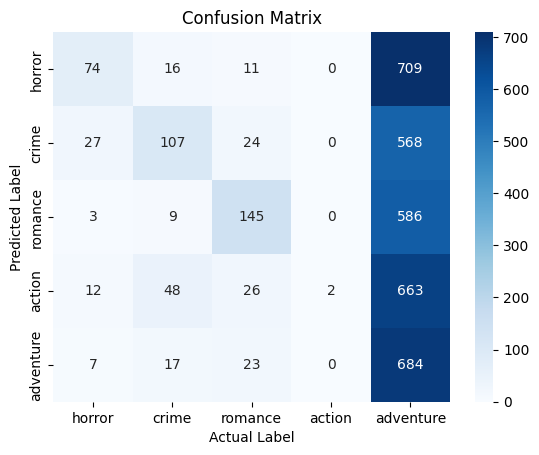

In [42]:
sns.heatmap(confusion_matrix_df, annot=True, fmt="g", cmap="Blues")

# Add labels and title
plt.xlabel("Actual Label")
plt.ylabel("Predicted Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()